## Sample size calculations for various approaches
Calculating the sample sizes for various approaches to answering the following questions
1. For evals where a code review or testing reveals a problem, how many transcripts must be evaluated to determine whether a benchmark has at least one violation demonstrated (Section 1)?
    - **This notebook** does this analysis, finding the n needed to achieve different levels of precision under different assumptions.
2. What percentage of transcripts demonstrate this violation? (Section 2)
3. For transcripts which demonstrate violations (as determined by gold standard human graders), how often is this violation detected by automated transcript analysis via scanners? (Section 3)


In [2]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt

## 1. How many samples must be run to rule out (or rule in) failure of a certain target
For each specific rubric piece, we would like to know whether a benchmark passes or fails with some degree of confidence without scanning every single transcript. This is dependent on the sensitivity (Se) and specificity (Sp) of the scanner (either human or model). Intuitively, the minimum threshold you can assess will be determined by Sp, as for very small true violation rates (p) your labeled violations will become dominated by false positives. Essentially, high Se means you need to run fewer samples and high Sp means you can verify to a lower threshold.

In some sense Sp can be corrected for by having a human auditor review flagged instances to determine whether they are true or false positives, so we don't need to get too carried away with this type of thing (or with trying to maximize Sp in the scanners). Still it's good to understand these things so we have a rough sense how many putative positives need to be found before a benchmark can be labeled as not passing (or, conversely, how many negatives need to be found before ruling it as passing)


### Case 1: adjudication of positives
In this world you are manually confirming any positive results. This means that we are assuming that specificity is 1 (there are never any false positives) which makes it fair for us drive accuracy to any arbitrary low threshold. **This is the sample size we can use for human grading to determine whether a benchmark passes the criteria**

In [3]:
# Calculate n >= ln(0.05) / ln(1 - p_0 * Se)
# This is the sample size needed to have 95% probability of detecting at least one true positive

def n_detect_one(p_0, se, alpha=0.05):
    """
    Calculate minimum n to have (1-alpha) probability of detecting at least one true positive.
    
    The probability of detecting at least one TP in n samples is: 1 - (1 - p_0 * Se)^n
    Setting this >= 1-alpha and solving for n gives: n >= ln(alpha) / ln(1 - p_0 * Se)
    
    Parameters
    ----------
    p_0 : float
        True prevalence (base rate), 0 < p_0 < 1
    se : float
        Sensitivity (true positive rate), 0 < se <= 1
    alpha : float
        Probability of failing to detect any positives (default 0.05 for 95% confidence)
    
    Returns
    -------
    float
        Minimum sample size (ceiling)
    """
    detection_prob = p_0 * se
    if detection_prob <= 0 or detection_prob >= 1:
        return np.inf
    
    n = np.log(alpha) / np.log(1 - detection_prob)
    return np.ceil(n)


def grid_n_detect_one(p_0s, ses, alpha=0.05):
    """
    Generate a DataFrame of required sample sizes for detecting at least one true positive.
    """
    rows = []
    for p_0 in p_0s:
        for se in ses:
            n = n_detect_one(p_0, se, alpha)
            rows.append({'p_0': p_0, 'sensitivity': se, 'n_required': n})
    return pd.DataFrame(rows)


# Define parameter ranges
p_0s = [0.01, 0.02, 0.03, 0.05, 0.10]  # prevalence values
ses = [0.8, 0.85, 0.9, 0.95, 0.99, 1.0]  # sensitivity values

# Generate the dataframe
df_detect = grid_n_detect_one(p_0s, ses)

# Pivot for easier viewing: rows = p_0, columns = sensitivity
df_pivot = df_detect.pivot(index='p_0', columns='sensitivity', values='n_required')
print("Sample sizes needed for 95% probability of detecting at least one true positive:")
print(df_pivot.to_string())


Sample sizes needed for 95% probability of detecting at least one true positive:
sensitivity   0.80   0.85   0.90   0.95   0.99   1.00
p_0                                                  
0.01         373.0  351.0  332.0  314.0  302.0  299.0
0.02         186.0  175.0  165.0  157.0  150.0  149.0
0.03         124.0  116.0  110.0  104.0  100.0   99.0
0.05          74.0   69.0   66.0   62.0   60.0   59.0
0.10          36.0   34.0   32.0   31.0   29.0   29.0


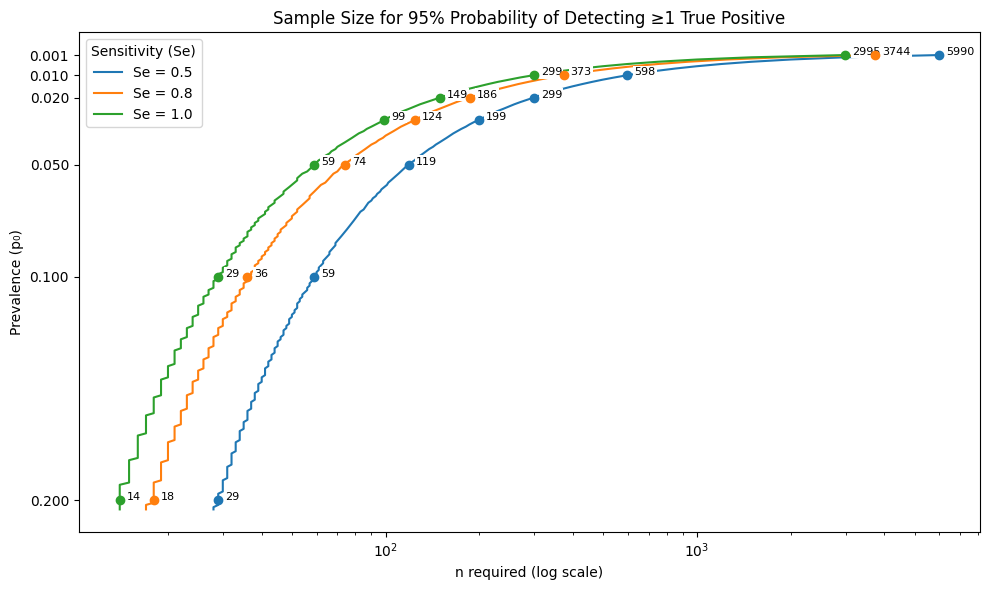

In [6]:
# Fine-grained data for smooth lines
p_0s_fine = np.arange(0.001, 0.205, 0.001)  # prevalence values
p_0s = [0.01, 0.02, 0.03, 0.05, 0.20]  # prevalence values
ses = [0.5, 0.8, 1.0]
df_fine = grid_n_detect_one(p_0s_fine, ses)

# Sparse data for points and labels
p_0s_points = [0.001,0.01, 0.02, 0.03, 0.05, 0.10, .20]
df_points = grid_n_detect_one(p_0s_points, ses)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.tab10.colors

for i, (se, group) in enumerate(df_fine.groupby('sensitivity')):
    # Draw smooth lines
    ax.plot(group['n_required'], group['p_0'], color=colors[i], label=f'Se = {se}')
    
    # Draw points at specific p_0 values
    points = df_points[df_points['sensitivity'] == se]
    ax.scatter(points['n_required'], points['p_0'], color=colors[i], zorder=5)
    
    # Add labels at points
    for _, row in points.iterrows():
        ax.annotate(f'{int(row["n_required"])}', 
                    (row['n_required'], row['p_0']),
                    textcoords='offset points',
                    xytext=(5, 0),
                    fontsize=8,
                    bbox=dict(facecolor='white', edgecolor='none', pad=1))

ax.set_xscale('log')
ax.invert_yaxis()
ax.set_yticks([0.001,0.01, 0.02, 0.05, 0.10, 0.20])
ax.set_xlabel('n required (log scale)')
ax.set_ylabel('Prevalence (p₀)')
ax.legend(title='Sensitivity (Se)')
ax.set_title('Sample Size for 95% Probability of Detecting ≥1 True Positive')
plt.tight_layout()
plt.show()


### Case 2: Some amount of specificity < 1
Using human graders + validation, we can argue that specificity = 1 and that it's fair to fail a certain test as long as the number of examples = 1.

I'm unsure how much we should care about this. One possibility is that the scanner just returns some putative positives and the human running it goes and checks to confirm. 